In [1]:
from modeling.data_handling.data_loading import league_data_loader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
train_df = league_data_loader(range(2010, 2015))
val_df = league_data_loader(range(2015, 2016))
test_df = league_data_loader(range(2016, 2020))

100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


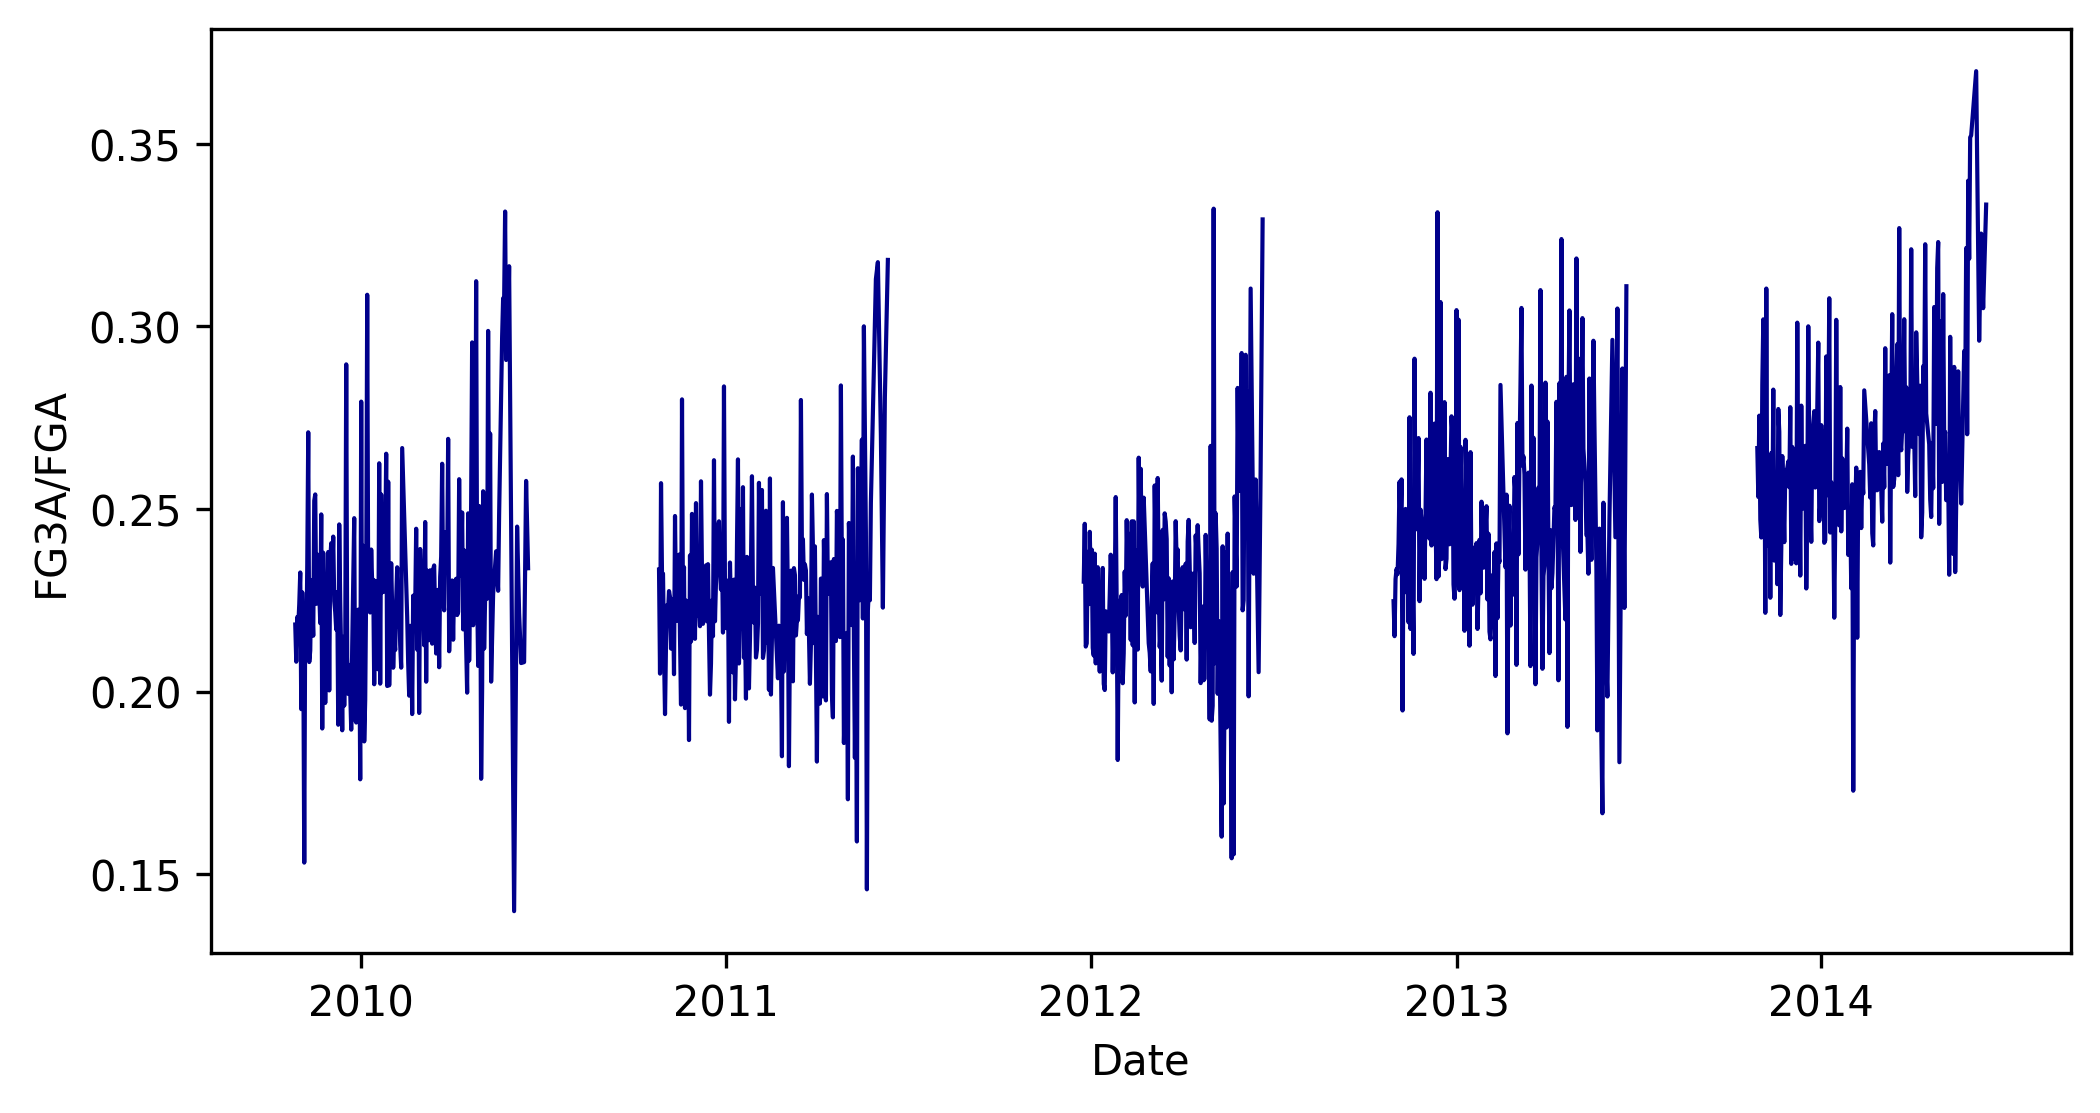

In [3]:
plt.figure(figsize=(8, 4), dpi=300)
for season in sorted(train_df.season.unique()):
    season_df = train_df[train_df.season == season]
    plt.plot(
        season_df.game_date, season_df.league_avg_fg3a_fga,
        color="darkblue", linewidth=1
    )
plt.xlabel("Date")
plt.ylabel("FG3A/FGA")
plt.savefig("plots/training-results.png", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
df = pd.read_csv("modeling/league_avg_fg3a_fga_predictions.csv")
df_lstm = pd.read_csv("modeling/lstm_test_predictions.csv")
df_cnn = pd.read_csv("modeling/cnn_test_predictions.csv")
df_hierarchical = pd.read_csv("modeling/hierarchical_league_data.csv")

In [5]:
def weighted_mse(true, pred, weights):
    return (weights * (true - pred) ** 2).sum() / weights.sum()

weighted_mse(df.league_avg_fg3a_fga, df.league_avg_fg3a_fga.mean(), df_lstm.fga)

0.001372641630738644

In [6]:
h_preds = df_hierarchical.league_predictions
print(
    weighted_mse(
        df_hierarchical.league_avg_fg3a_fga, h_preds, df_hierarchical.fga
    )
)
print(
    weighted_mse(
        df_hierarchical.league_avg_fg3a_fga,
        df_hierarchical.league_predictions,
        df_hierarchical.fga
    )
)

0.0018066574472260504
0.0018066574472260504


In [7]:
df_hierarchical = pd.read_csv("modeling/hierarchical_player_data.csv")
df_hierarchical = df_hierarchical[df_hierarchical.season.isin([2018, 2019])]
df_hierarchical.player_predictions[df_hierarchical.player_predictions < 0] = 0
h_df_ad = df_hierarchical[df_hierarchical.athlete_display_name == "Anthony Davis"]
h_df_bl = df_hierarchical[df_hierarchical.athlete_display_name == "Brook Lopez"]

0.0017163215928190222
[[1.         0.87273352]
 [0.87273352 1.        ]]


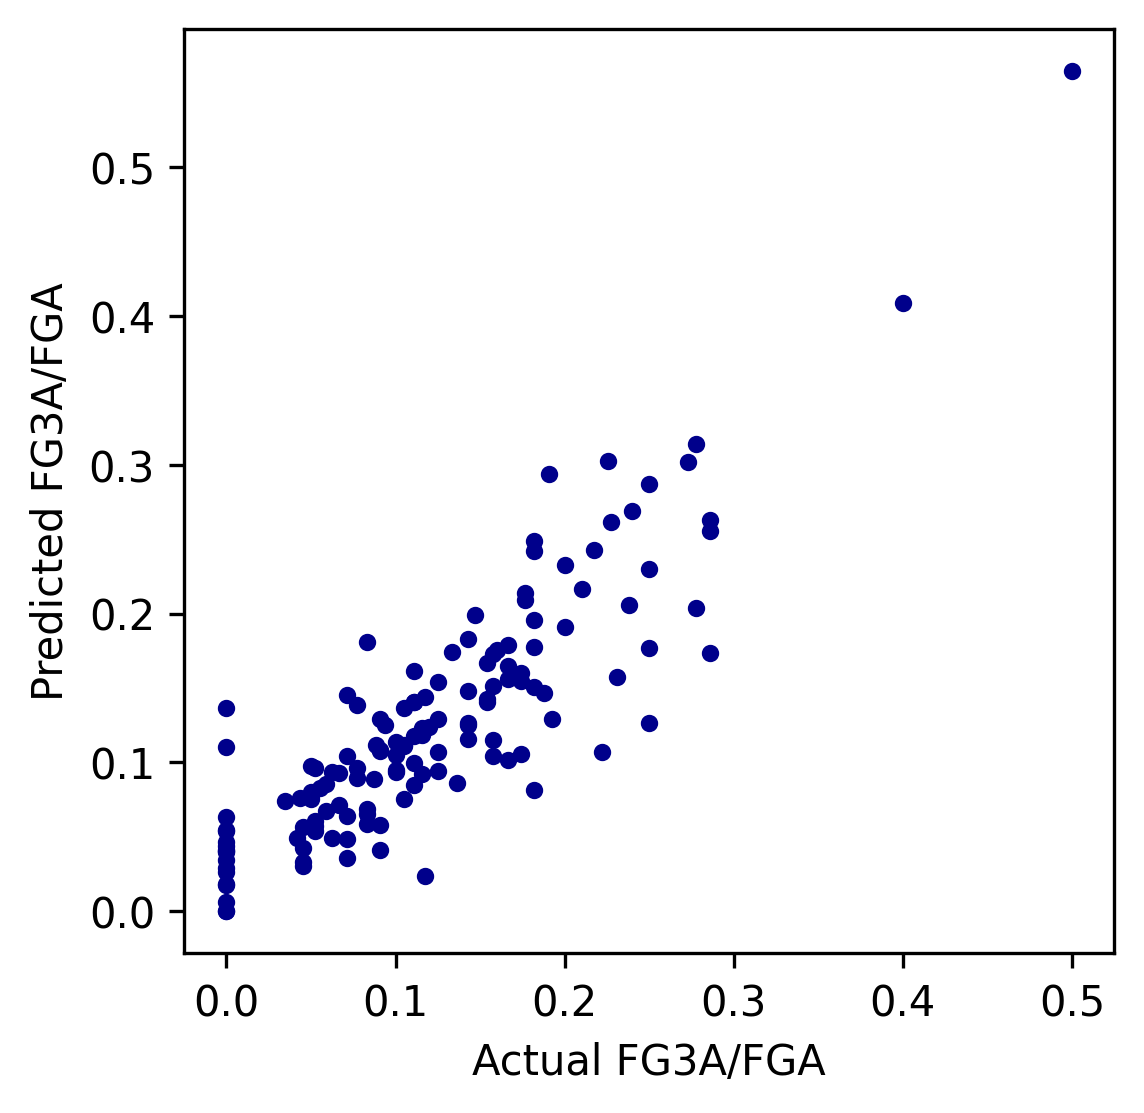

In [8]:
print(weighted_mse(h_df_ad.fg3a_fga, h_df_ad.player_predictions, h_df_ad.fga))
print(np.corrcoef(h_df_ad.fg3a_fga, h_df_ad.player_predictions))
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(h_df_ad.fg3a_fga, h_df_ad.player_predictions, s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/ad-pred-actual.png", dpi=300, bbox_inches="tight")
plt.show()

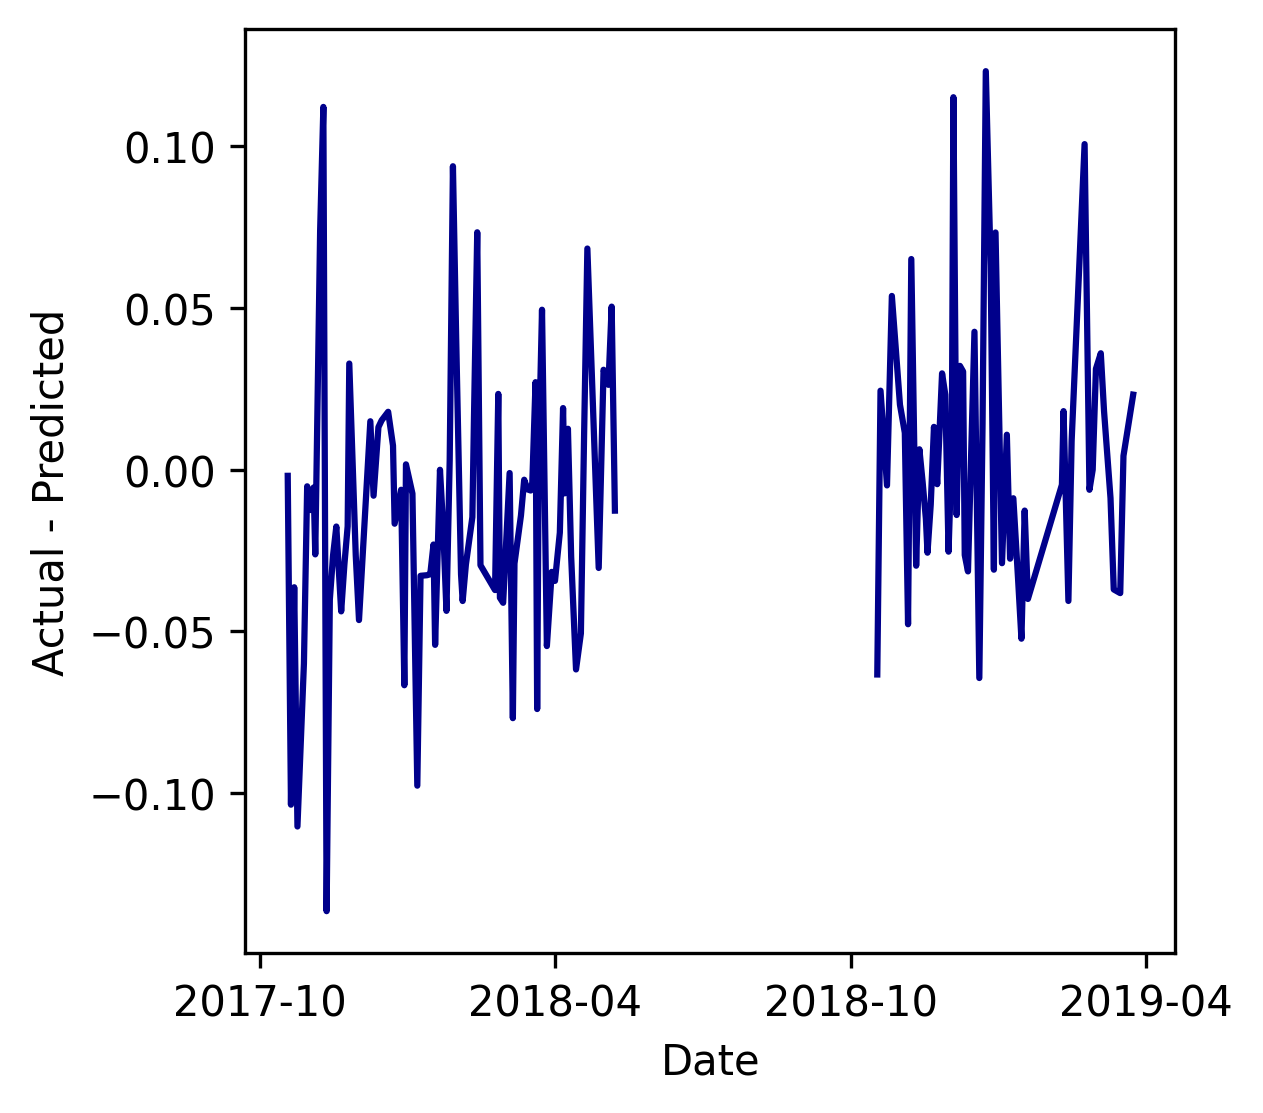

In [9]:
plt.figure(figsize=(4, 4), dpi=300)
dates = pd.to_datetime(h_df_ad.game_date)
true = h_df_ad.fg3a_fga
preds = h_df_ad.player_predictions
plt.plot(
    dates[dates < "2018-08-01"],
    (true - preds)[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    color="darkblue"
)
plt.plot(dates[dates >= "2018-08-01"], (true - preds)[dates >= "2018-08-01"], color="darkblue")
plt.xticks(["2017-10", "2018-04", "2018-10", "2019-04"], ["2017-10", "2018-04", "2018-10", "2019-04"])
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/ad-residuals.png", dpi=300, bbox_inches="tight")
plt.show()

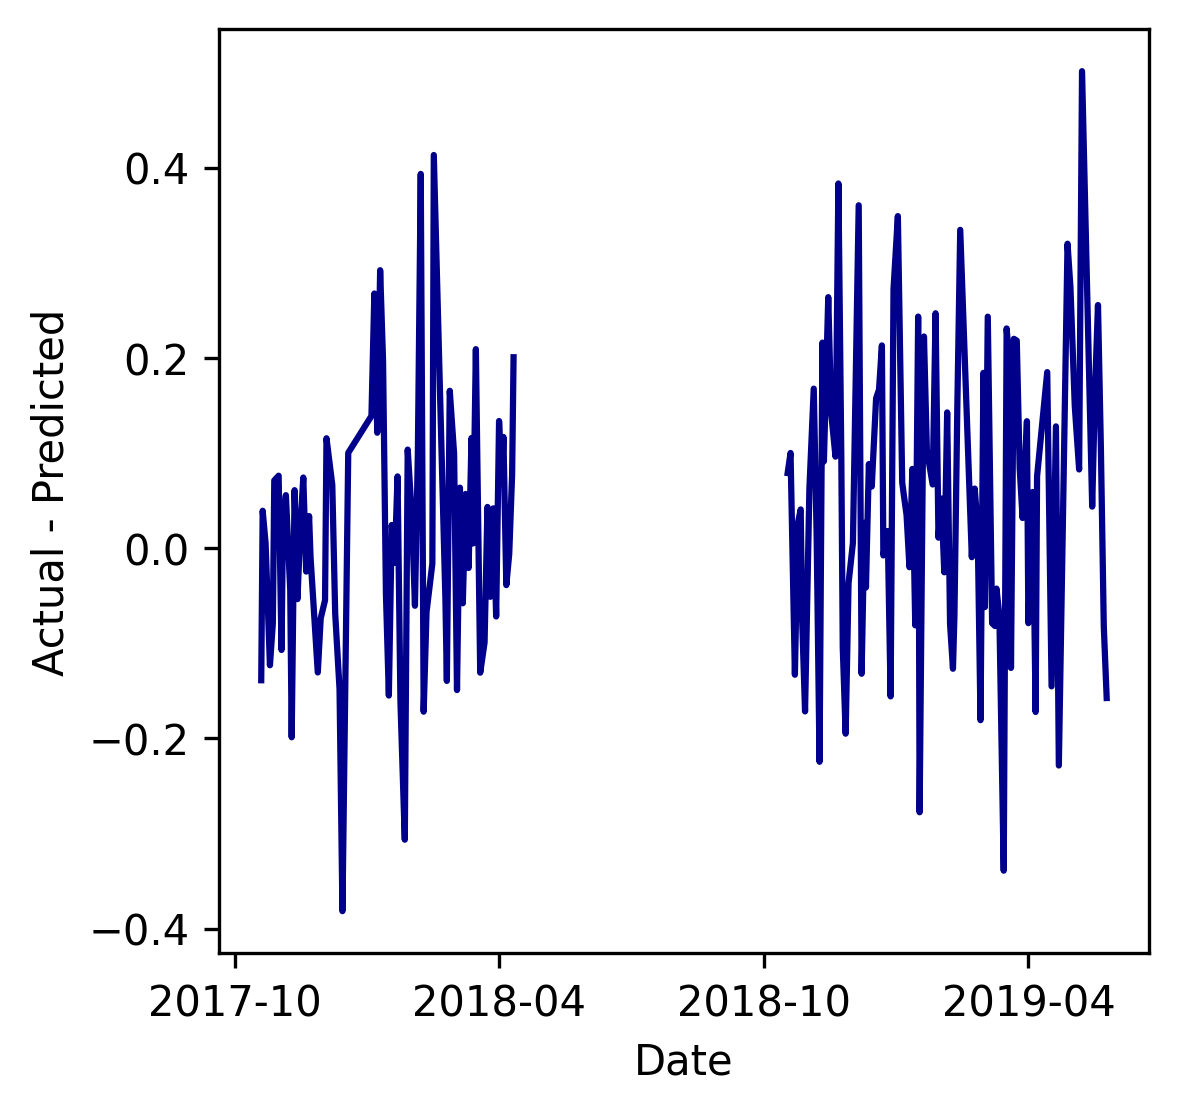

In [10]:
plt.figure(figsize=(4, 4), dpi=300)
dates = pd.to_datetime(h_df_bl.game_date)
true = h_df_bl.fg3a_fga
preds = h_df_bl.player_predictions
plt.plot(
    dates[dates < "2018-08-01"],
    (true - preds)[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    color="darkblue"
)
plt.plot(dates[dates >= "2018-08-01"], (true - preds)[dates >= "2018-08-01"], color="darkblue")
plt.xticks(["2017-10", "2018-04", "2018-10", "2019-04"], ["2017-10", "2018-04", "2018-10", "2019-04"])
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/bl-residuals.png", dpi=300, bbox_inches="tight")
plt.show()

0.02082938210522766
[[1.         0.69314461]
 [0.69314461 1.        ]]


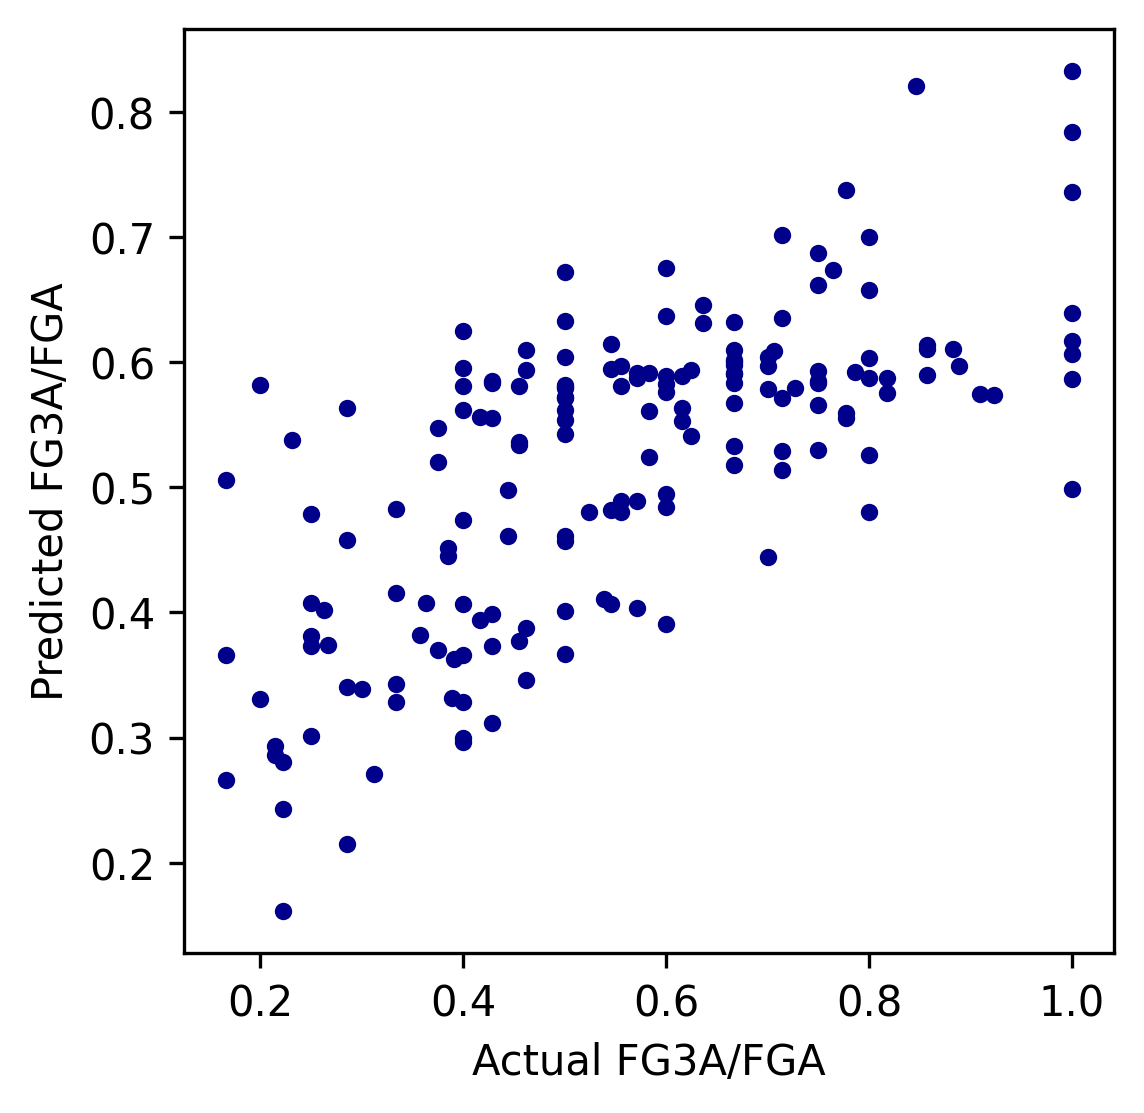

In [11]:
print(weighted_mse(h_df_bl.fg3a_fga, h_df_bl.player_predictions, h_df_bl.fga))
print(np.corrcoef(h_df_bl.fg3a_fga, h_df_bl.player_predictions))
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(h_df_bl.fg3a_fga, h_df_bl.player_predictions, s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/bl-pred-actual.png", dpi=300, bbox_inches="tight")
plt.show()

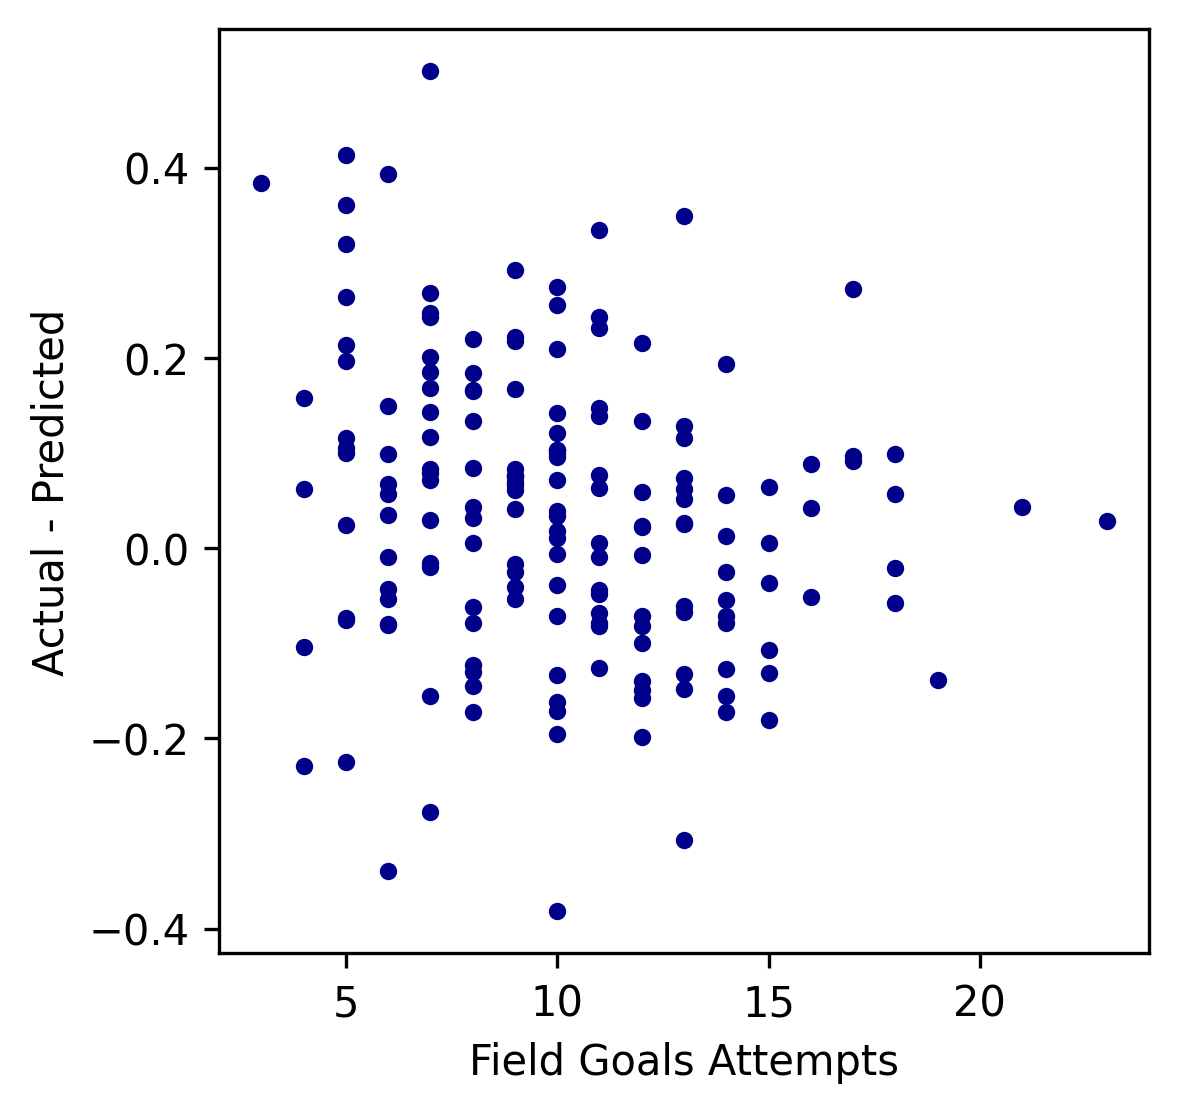

In [12]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(h_df_bl.fga, h_df_bl.fg3a_fga - h_df_bl.player_predictions, s=10, color="darkblue")
plt.xlabel("Field Goals Attempts")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/bl-residuals-weights.png", dpi=300, bbox_inches="tight")
plt.show()

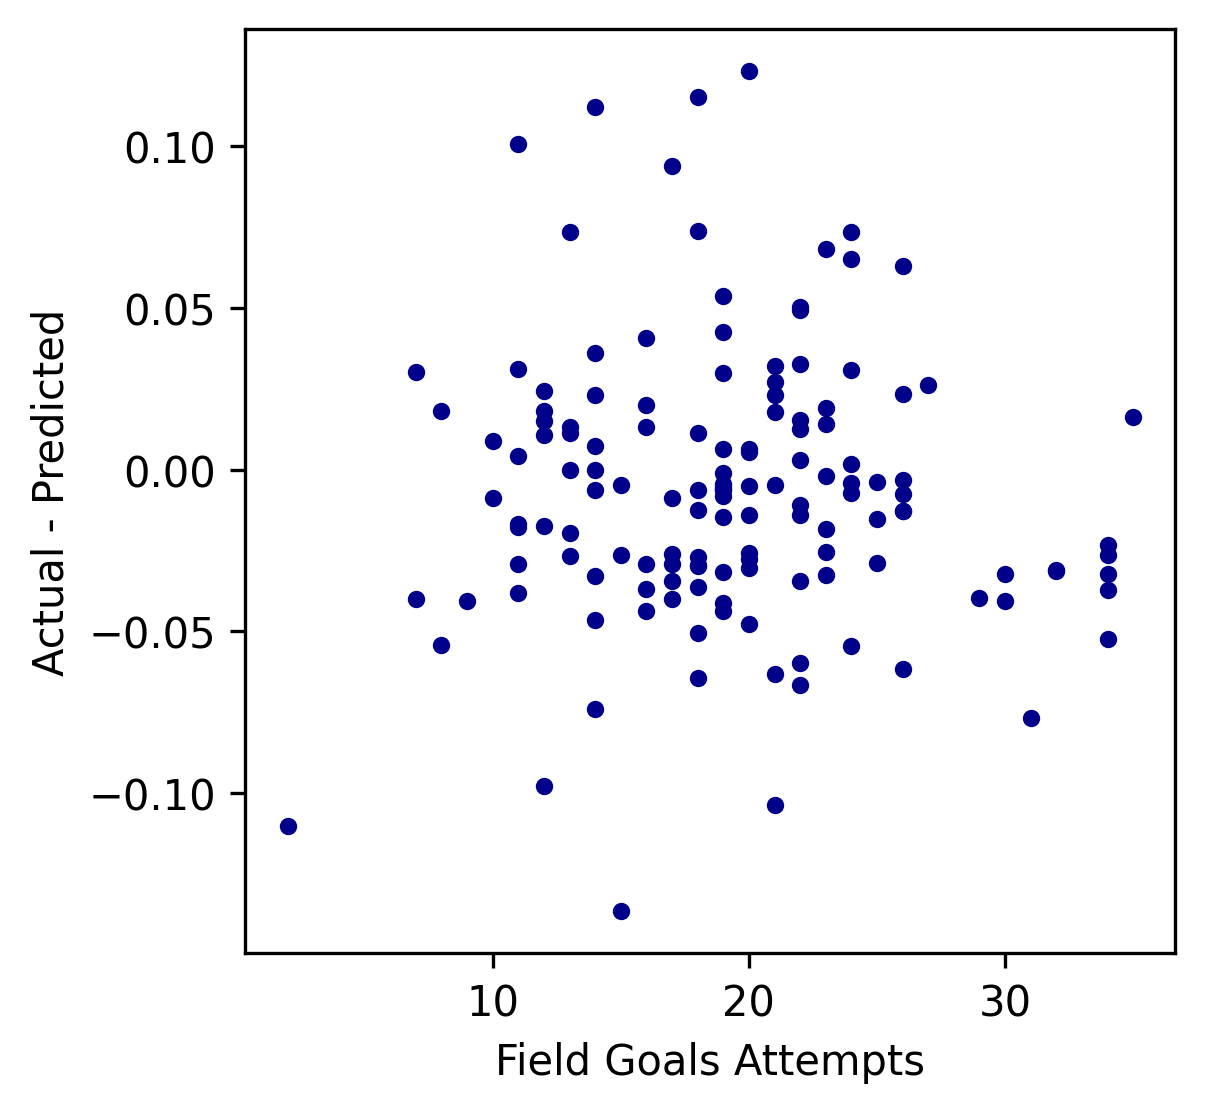

In [13]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(h_df_ad.fga, h_df_ad.fg3a_fga - h_df_ad.player_predictions, s=10, color="darkblue")
plt.xlabel("Field Goals Attempts")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/ad-residuals-weights.png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
print(mean_squared_error(df.league_avg_fg3a_fga, df.predicted_league_avg_fg3a_fga))
print(r2_score(df.league_avg_fg3a_fga, df.predicted_league_avg_fg3a_fga))
print(weighted_mse(df.league_avg_fg3a_fga, df.predicted_league_avg_fg3a_fga, df_lstm.fga))

0.0009625766473421483
0.4593597363423908
0.0006291562388663707


[[1.         0.59335946]
 [0.59335946 1.        ]]


0.0010087000942296791

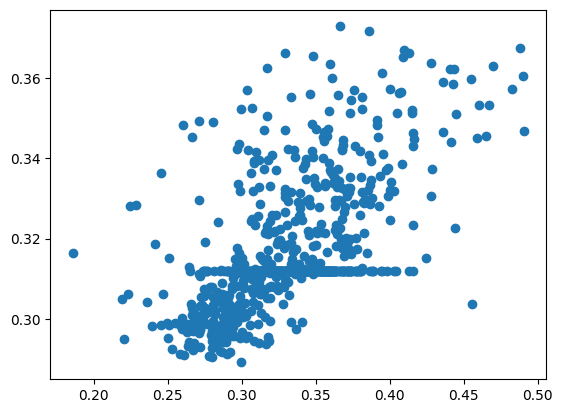

In [15]:
# Adjust to have predictions be correct for date_time
plt.scatter(df_lstm.league_avg_fg3a_fga[4:], df_lstm.Predictions[:-4])
print(np.corrcoef(df_lstm.league_avg_fg3a_fga.iloc[4:], df_lstm.Predictions[:-4]))
weighted_mse(df_lstm.league_avg_fg3a_fga.iloc[4:],df_lstm.Predictions[:-4], df_lstm.fga.iloc[4:])

0.0012269270035259988
0.3095631439291636
[[1.         0.65576286]
 [0.65576286 1.        ]]
0.000449135787951562


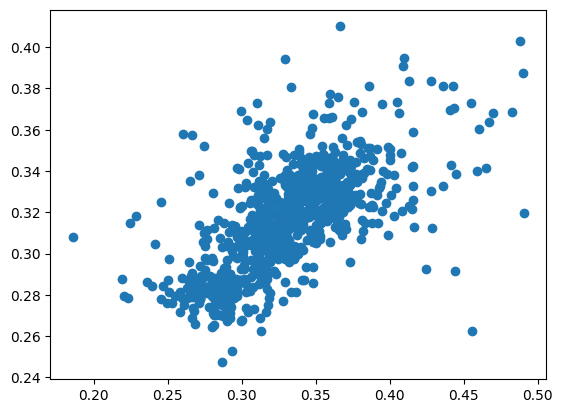

In [16]:
plt.scatter(df_cnn.league_avg_fg3a_fga[4:], df_cnn.Predictions[:-4])
print(mean_squared_error(df_cnn.league_avg_fg3a_fga.iloc[4:], df_cnn.Predictions[:-4]))
print(r2_score(df_cnn.league_avg_fg3a_fga.iloc[4:], df_cnn.Predictions[:-4]))
print(np.corrcoef(df_cnn.league_avg_fg3a_fga.iloc[4:], df_cnn.Predictions[:-4]))
print(weighted_mse(df_cnn.league_avg_fg3a_fga.iloc[4:],
             df_cnn.Predictions[:-4],
              df_cnn.fga.iloc[4:]
            ))
plt.show()

In [17]:
preds = df_cnn.Predictions.iloc[:-4].reset_index(drop=True)
dates = pd.to_datetime(df.game_date.iloc[3:].reset_index(drop=True))
true = df_cnn.league_avg_fg3a_fga.iloc[4:].reset_index(drop=True)
weights = df_cnn.fga.iloc[4:].reset_index(drop=True)

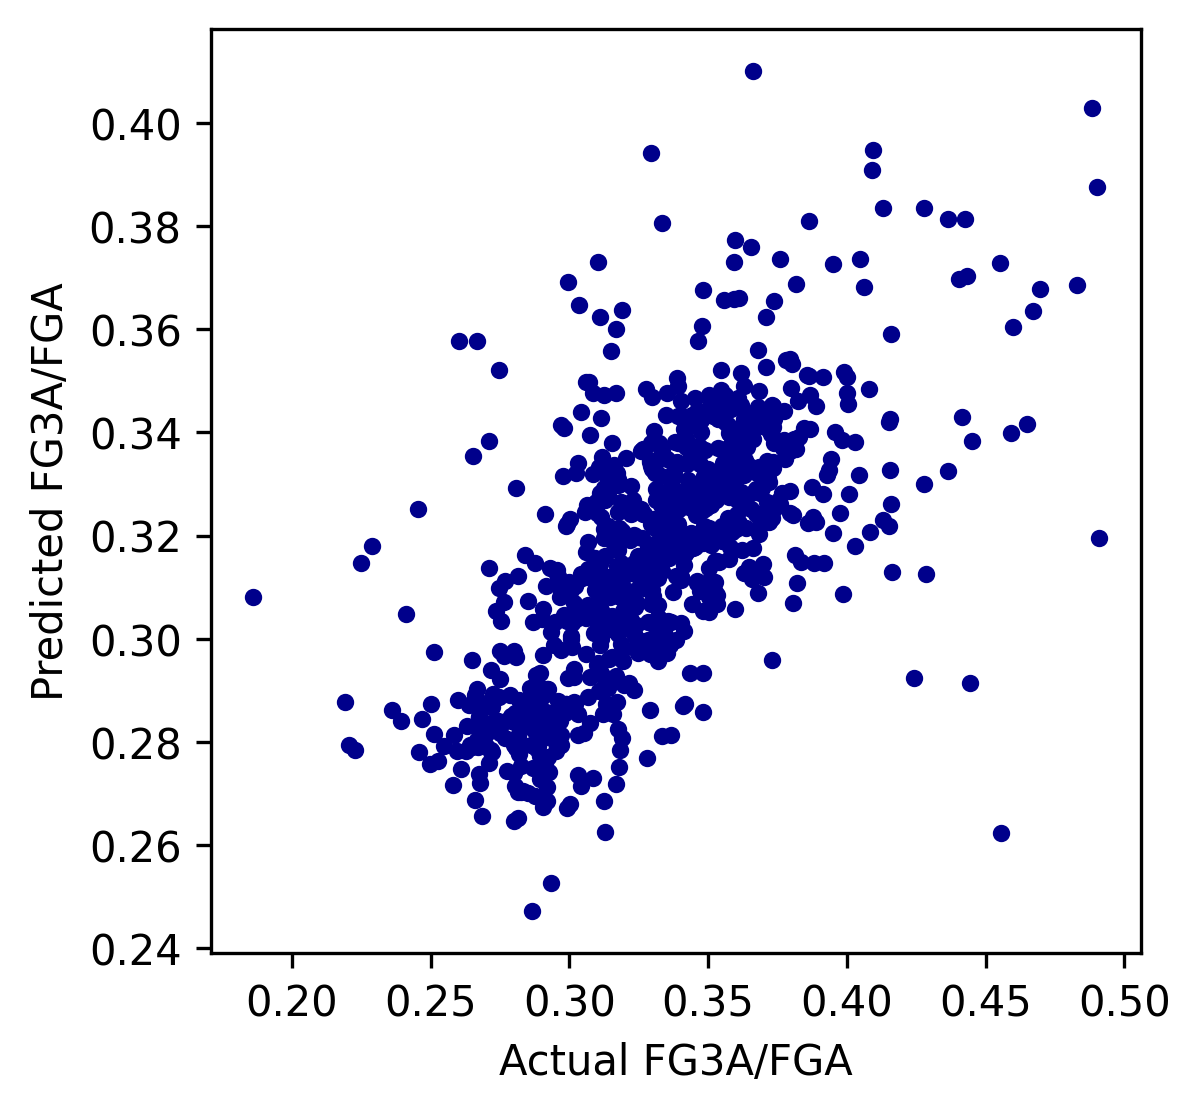

In [18]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(true, preds, s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/preds-actual.png", dpi=300, bbox_inches="tight")
plt.show()

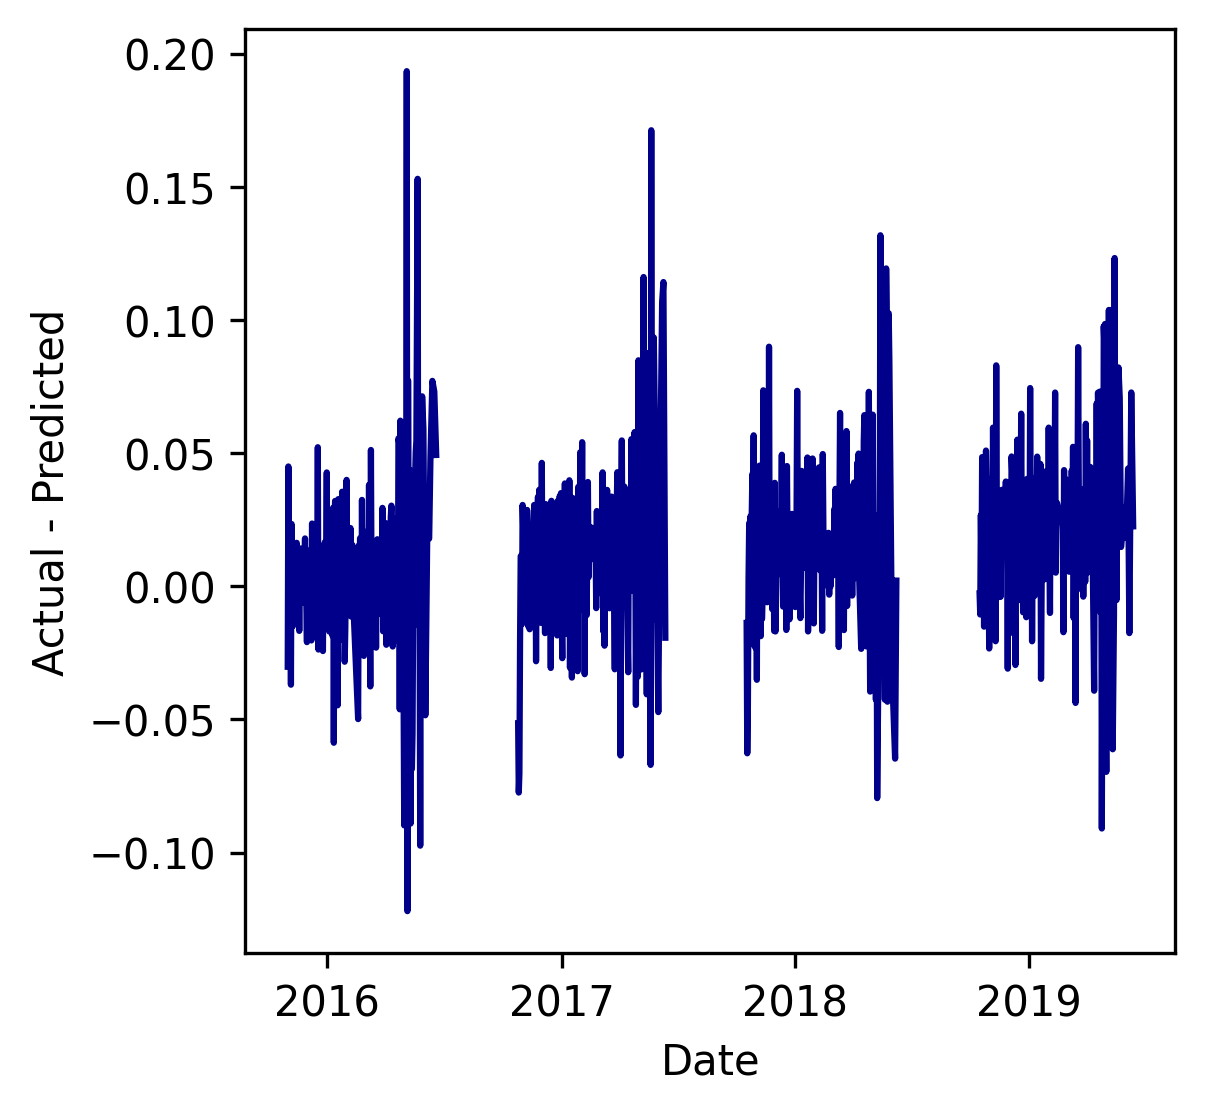

In [19]:
plt.figure(figsize=(4, 4), dpi=300)
plt.plot(dates[dates < "2016-08-01"], (true - preds)[dates < "2016-08-01"], color="darkblue")
plt.plot(
    dates[(dates < "2017-08-01") & (dates >= "2016-08-01")],
    (true - preds)[(dates < "2017-08-01") & (dates >= "2016-08-01")],
    color="darkblue"
)
plt.plot(
    dates[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    (true - preds)[(dates < "2018-08-01") & (dates >= "2017-08-01")],
    color="darkblue"
)
plt.plot(dates[dates >= "2018-08-01"], (true - preds)[dates >= "2018-08-01"], color="darkblue")
plt.xticks(["2016-01-01", "2017-01-01", "2018-01-01", "2019-01-01"], [*range(2016, 2020)])
plt.xlabel("Date")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/residuals.png", dpi=300, bbox_inches="tight")
plt.show()

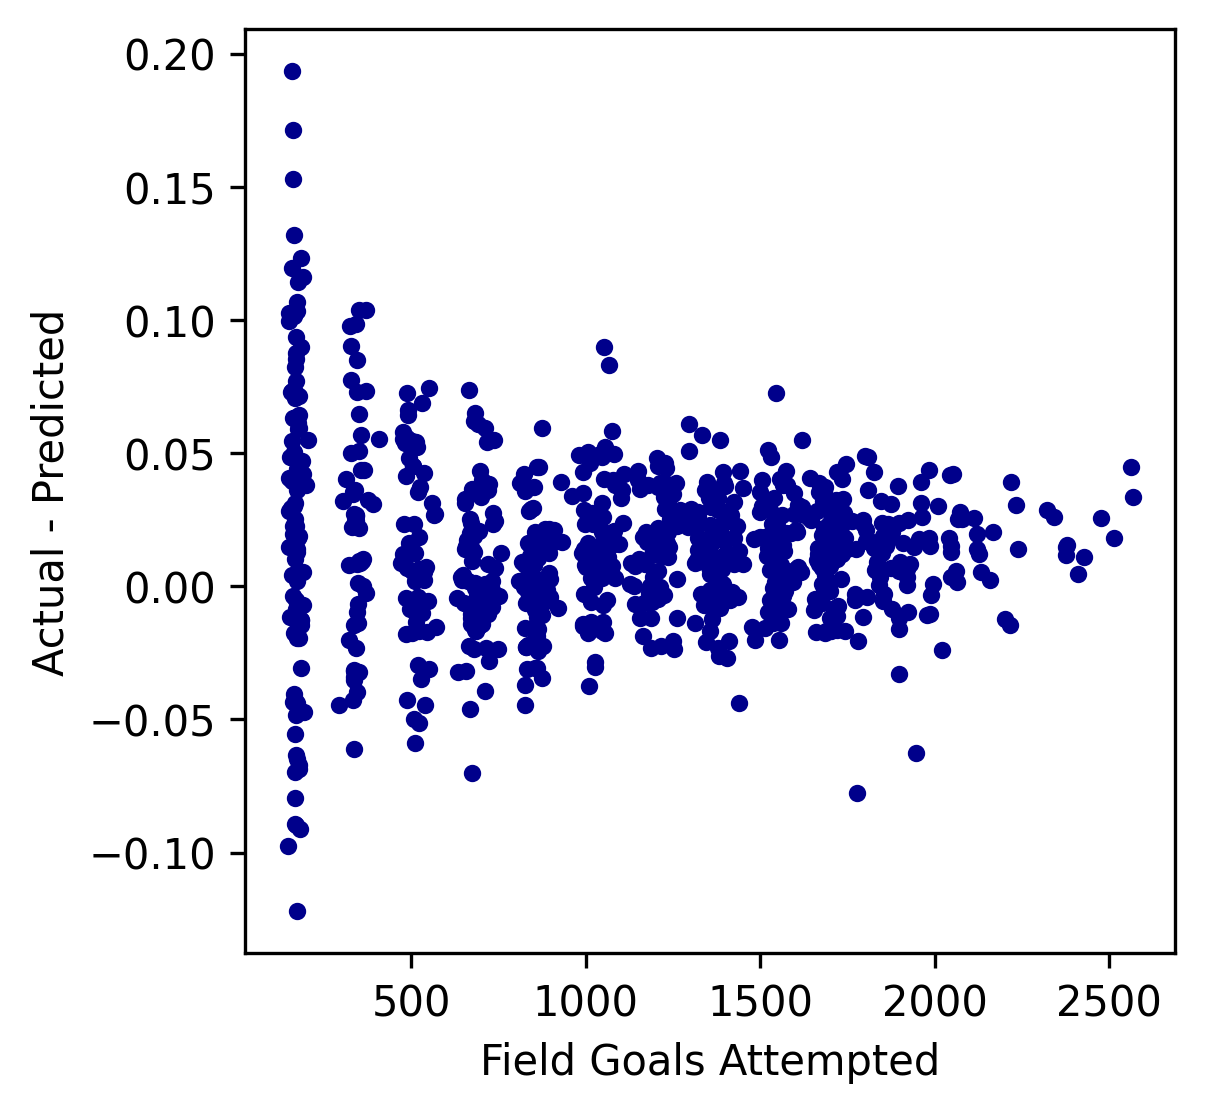

In [20]:
plt.figure(figsize=(4, 4), dpi=300)
plt.scatter(weights, true - preds, s = 10, color="darkblue")
plt.xlabel("Field Goals Attempted")
plt.ylabel("Actual - Predicted")
plt.savefig("plots/residuals-weights.png", dpi=300, bbox_inches="tight")

In [21]:
df_bl = pd.read_csv("modeling/Brook Lopez_fg3a_fga_predictions.csv")
print(mean_squared_error(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga']))
r2_score(y_true=df_bl['fg3a_fga'], y_pred=df_bl['predicted_player_fg3a_fga'])

0.038556145027120854


0.09829409429142177

In [22]:
df_bl = pd.read_csv("modeling/Brook Lopez_fg3a_fga_predictions_CNN.csv")
print(mean_squared_error(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_bl['fg3a_fga'], y_pred=df_bl['predicted_player_fg3a_fga']))
print(weighted_mse(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'], df_bl.field_goals_attempted))

0.038742960563309836
0.09392507160667918
0.036509016582615884


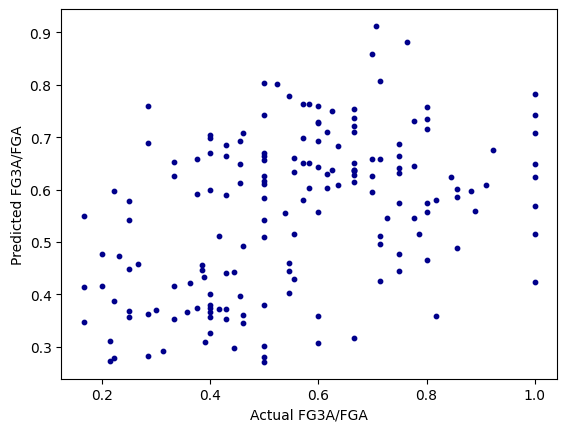

In [23]:
plt.scatter(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'], s=10, color="darkblue")
plt.xlabel("Actual FG3A/FGA")
plt.ylabel("Predicted FG3A/FGA")
plt.savefig("plots/bl-pred-actual.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
np.corrcoef(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'])

array([[1.        , 0.42598967],
       [0.42598967, 1.        ]])

In [25]:
df_ad = pd.read_csv("modeling/Anthony Davis_fg3a_fga_predictions_CNN.csv")
print(mean_squared_error(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_ad['fg3a_fga'], y_pred=df_ad['predicted_player_fg3a_fga']))
print(weighted_mse(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], df_ad.field_goals_attempted))

0.006920900640702241
0.05718584790370318
0.006211971295548302


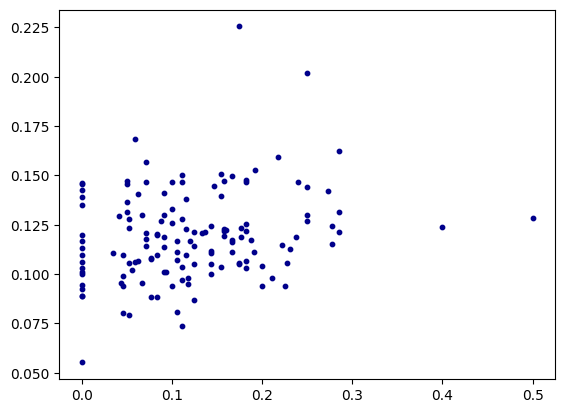

In [26]:
plt.scatter(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], s=10, color="darkblue")

In [27]:
np.corrcoef(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'])

array([[1.        , 0.24120603],
       [0.24120603, 1.        ]])

In [28]:
df_bl = pd.read_csv("modeling/Brook Lopez_fg3a_fga_predictions_LSTM.csv")
print(mean_squared_error(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_bl['fg3a_fga'], y_pred=df_bl['predicted_player_fg3a_fga']))
print(weighted_mse(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'], df_bl.field_goals_attempted))

0.038612516199656124
0.09697575141375558
0.03607434897887773


In [29]:
print(weighted_mse(df_bl['fg3a_fga'], df_bl['predicted_player_fg3a_fga'].mean(), df_bl.field_goals_attempted))

0.04175659035602606


In [30]:
df_ad = pd.read_csv("modeling/Anthony Davis_fg3a_fga_predictions_LSTM.csv")
print(mean_squared_error(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_ad['fg3a_fga'], y_pred=df_ad['predicted_player_fg3a_fga']))
print(weighted_mse(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], df_ad.field_goals_attempted))

0.0071729740981135055
0.022846614420491518
0.006495711122541015


In [31]:
df_ad = pd.read_csv("modeling/Anthony Davis_fg3a_fga_predictions_LSTM.csv")
print(mean_squared_error(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga']))
print(r2_score(y_true=df_ad['fg3a_fga'], y_pred=df_ad['predicted_player_fg3a_fga']))
print(weighted_mse(df_ad['fg3a_fga'], df_ad['predicted_player_fg3a_fga'], df_ad.field_goals_attempted))

0.0071729740981135055
0.022846614420491518
0.006495711122541015


In [32]:
print(weighted_mse(df_ad['fg3a_fga'], df_ad['fg3a_fga'].mean(), df_ad.field_goals_attempted))

0.006518105668644251
